# Libraries

In [ ]:
!nvidia-smi

Tue Sep 13 07:07:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    38W / 300W |   2171MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
ROOT_PATH = '/content/drive/My Drive/09_research_main/lab_01'

In [ ]:
!pip install fastai==1.0.58
!pip install torch==1.4.0
!pip install torchvision==0.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 236 kB 15.4 MB/s 
     |████████████████████████████████| 355 kB 75.7 MB/s 
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19190 sha256=e478b218365063a2eadddc7905c9f21d49bbc714cf1d011762642385c12452da
  Stored in directory: /root/.cache/pip/wheels/df/99/da/c34f202dc8fd1dffd35e0ecf1a7d7f8374ca05fbcbaf974b83
Successfully built nvidia-ml-py3
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.9
    Uninstalling fastai-2.7.9:
      Successfully uninstalled fastai-2.7.9
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 753.4 MB 6.4 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113


In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Importing the FastAI libraries:

In [ ]:
from fastai.vision import *
from fastai.metrics import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [ ]:

from datetime import datetime
from time import time

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# import warnings

import fastai
# from fastai.vision import *
from fastai.callbacks import *
# from fastai.callbacks.hooks import *
# from fastai.utils.mem import *

In [ ]:
from fastai.utils.show_install import show_install; show_install()



```text
=== Software === 
python        : 3.7.13
fastai        : 1.0.58
fastprogress  : 1.0.3
torch         : 1.4.0
nvidia driver : 460.32
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16160MB | Tesla V100-SXM2-16GB

=== Environment === 
platform      : Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Fri Aug 26 08:44:51 UTC 2022
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : /content
/env/python
/usr/lib/python37.zip
/usr/lib/python3.7
/usr/lib/python3.7/lib-dynload

/usr/local/lib/python3.7/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.7/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once in

# Dataset

In [ ]:
def checkpath(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
# model

Version = 'M_v_6.0.0'

root_folder = os.path.abspath(os.path.join(ROOT_PATH, Version))

model_DIR = os.path.abspath(os.path.join(root_folder, 'model'))
checkpath(model_DIR)

In [ ]:
# dataset

Version = 'data/dataset_C_v_2.8.1'

root_folder = os.path.abspath(os.path.join(ROOT_PATH, Version))

trainpath = os.path.join(root_folder, 'train_for_base_imgs/')

trainlabel = os.path.join(root_folder, 'train_for_base_mask/')

classescsv_path = os.path.join(root_folder, 'classes.csv')

In [ ]:
# # Defining the path where my JPG images are stored:
# trainpath = os.path.join(ROOT_PATH, "data/NORMAL/mask/jpgs/")

# # Defining the path where the mask PNG images of the images mentioned above are stored:
# trainlabel = os.path.join(ROOT_PATH, "data/NORMAL/mask/new_mask/")

# Taking out the JPG filenames out of the training data folder:
fnames = get_image_files(trainpath)

Below is a function which defines how our data module will find the labels to the images it learns segmentation with. Lambda in layman's language here refers to defining a function with input x.

*trainlabel* refers to the folder path where all the labels are stored.

*x.stem* refers to the image's name while, .PNG is concatenated with it because the mask is not a JPG but a PNG. 

In [ ]:
get_y = lambda x: trainlabel + x.stem + '.png' 

Lets take a look at the images and their respective masks:

In [ ]:
for i in range(0,4):
    img = open_image(fnames[i])
    mask = open_mask(get_y(fnames[i]))
#     img.show(figsize=(6,6)), mask.show(figsize=(6,6), alpha=1)

Noting important measures:

In [ ]:
src_shape = np.array(mask.shape[1:])

size = src_shape // 2

bs = 8

The classes are stored in a csv so taking a look at it:

In [ ]:
classescsv = pd.read_csv(classescsv_path)

# classescsv.head()

I will now seperate out the _class since it contains the classes and turn it into a list:

In [ ]:
classes = list(classescsv['_class'])

Finally defining the data our model will run on:

In [ ]:
trainpath = os.path.join(root_folder, 'train_for_base_imgs/')
trainlabel = os.path.join(root_folder, 'train_for_base_mask/')

trainpath_ = os.path.join(root_folder, 'train_for_step_imgs/')
trainlabel_ = os.path.join(root_folder, 'train_for_step_mask/')

validpath = os.path.join(root_folder, 'valid_imgs/')
validlabel = os.path.join(root_folder, 'valid_mask/')

testpath = os.path.join(root_folder, 'test_imgs/')
testlabel = os.path.join(root_folder, 'test_mask/')

In [ ]:
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self

fastai.data_block.ItemLists.transform = transform

In [ ]:
def get_mask(imgs_name):
  if str(imgs_name).split('/')[-2] == 'train_for_base_imgs' :
    return trainlabel
  else:
    return validlabel

In [ ]:
get_z = lambda x: get_mask(x) + x.stem + '.png'

In [ ]:
data = (SegmentationItemList.from_folder(root_folder)
        .split_by_folder(train='train_for_base_imgs', valid='valid_imgs')
        .label_from_func(get_z, classes=classes)
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        # .normalize(imagenet_stats)
       )

In [ ]:
data

ImageDataBunch;

Train: LabelList (3338 items)
x: SegmentationItemList
Image (3, 540, 540),Image (3, 540, 540),Image (3, 540, 540),Image (3, 540, 540),Image (3, 540, 540)
y: SegmentationLabelList
ImageSegment (1, 540, 540),ImageSegment (1, 540, 540),ImageSegment (1, 540, 540),ImageSegment (1, 540, 540),ImageSegment (1, 540, 540)
Path: /content/drive/My Drive/09_research_main/lab_01/data/dataset_C_v_2.8.1;

Valid: LabelList (917 items)
x: SegmentationItemList
Image (3, 540, 540),Image (3, 540, 540),Image (3, 540, 540),Image (3, 540, 540),Image (3, 540, 540)
y: SegmentationLabelList
ImageSegment (1, 540, 540),ImageSegment (1, 540, 540),ImageSegment (1, 540, 540),ImageSegment (1, 540, 540),ImageSegment (1, 540, 540)
Path: /content/drive/My Drive/09_research_main/lab_01/data/dataset_C_v_2.8.1;

Test: None

Taking a look at an image with its mask:

In [ ]:
# data.show_batch(2, figsize=(6,6))

Defining and downloading the UNet:

# Model

In [ ]:
def cust_accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

In [ ]:
# Return Jaccard index, or Intersection over Union (IoU) value
def IoU(preds:Tensor, targs:Tensor, eps:float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value 
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]
    
    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]
        
        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()   # find mean of class IoU values
    return iou

In [ ]:
def dice(input:Tensor, targs:Tensor, eps:float=1e-8)->Rank0Tensor:
    input = input.clone()
    targs = targs.clone()
    n = targs.shape[0]
    input = torch.softmax(input, dim=1).argmax(dim=1)
    input = input.view(n, -1)
    targs = targs.view(n, -1)
    input[input == 0] = -999
    intersect = (input == targs).sum().float()
    union = input[input > 0].sum().float() + targs[targs > 0].sum().float()
    del input, targs
    gc.collect()
    return ((2.0 * intersect + eps) / (union + eps)).mean()

In [ ]:
def fmt_now():
    return datetime.today().strftime('%Y%m%d-%H%M%S')

In [ ]:
# adapted from: https://www.kaggle.com/iafoss/unet34-dice-0-87
# can use sigmoid on the input too, in this case the threshold would be 0.5
def dice_metric(pred, targs, threshold=0):
    pred = (pred > threshold).float()
    targs = targs.float()
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

In [ ]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [ ]:
from torch import nn
import torch.nn.functional as F

class FocalLoss_C(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduction='elementwise_mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)

In [ ]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [ ]:
def dice_B(pred, targs):
    pred = (pred>0).float()
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

def IoU_B(pred, targs):
    pred = (pred>0).float()
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

In [ ]:
metrics = [dice, IoU, dice_metric, cust_accuracy, dice_B, IoU_B]

callback_fns = [
    ShowGraph,
    # partial(SaveModelCallback, every='epoch', name=f"{fmt_now()}_unet_resnet34"),   
    # stop training if metric no longer improve
    # partial(EarlyStoppingCallback, monitor='IoU', min_delta=0.01, patience=2),
]

learner = unet_learner(data, models.resnet34, metrics=metrics, wd=1e-2, callback_fns=callback_fns)
learner.model_dir = model_DIR

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
# learner.loss_func = FocalLoss_C()

In [ ]:
learner.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
print(learner)

Learner(data=ImageDataBunch;

Train: LabelList (3338 items)
x: SegmentationItemList
Image (3, 540, 540),Image (3, 540, 540),Image (3, 540, 540),Image (3, 540, 540),Image (3, 540, 540)
y: SegmentationLabelList
ImageSegment (1, 540, 540),ImageSegment (1, 540, 540),ImageSegment (1, 540, 540),ImageSegment (1, 540, 540),ImageSegment (1, 540, 540)
Path: /content/drive/My Drive/09_research_main/lab_01/data/dataset_C_v_2.8.1;

Valid: LabelList (917 items)
x: SegmentationItemList
Image (3, 540, 540),Image (3, 540, 540),Image (3, 540, 540),Image (3, 540, 540),Image (3, 540, 540)
y: SegmentationLabelList
ImageSegment (1, 540, 540),ImageSegment (1, 540, 540),ImageSegment (1, 540, 540),ImageSegment (1, 540, 540),ImageSegment (1, 540, 540)
Path: /content/drive/My Drive/09_research_main/lab_01/data/dataset_C_v_2.8.1;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2

In [ ]:
# learner.load(model_DIR)

In [ ]:
# learner.summary()

# Train

Training the data:

In [ ]:
# learner.lr_find()
# learner.recorder.plot(skip_end=10, suggestion=True)

epoch,train_loss,valid_loss,dice,IoU,dice_metric,cust_accuracy,dice_B,IoU_B,time
0,0.202348,0.164720,0.228664,0.402414,0.311282,0.937756,0.311282,0.185674,08:26
1,0.139394,0.150910,0.213788,0.434867,0.301318,0.942549,0.301318,0.178525,04:43
2,0.107190,0.095828,0.367193,0.558822,0.289637,0.963195,0.289637,0.170378,04:43
3,0.086459,0.088303,0.387013,0.598993,0.295272,0.967489,0.295272,0.174328,04:43
4,0.070533,0.081235,0.387347,0.628292,0.309015,0.968367,0.309015,0.183943,04:42
5,0.060128,0.074286,0.388415,0.640571,0.307652,0.972605,0.307652,0.183046,04:42
6,0.046690,0.096317,0.380475,0.637199,0.279594,0.968757,0.279594,0.163405,04:43
7,0.043404,0.072653,0.404505,0.662235,0.311305,0.971805,0.311305,0.185738,04:42
8,0.039087,0.066366,0.421057,0.698495,0.262389,0.976078,0.262389,0.151968,04:42
9,0.036360,0.074403,0.393389,0.659417,0.289689,0.972554,0.289689,0.170464,04:43


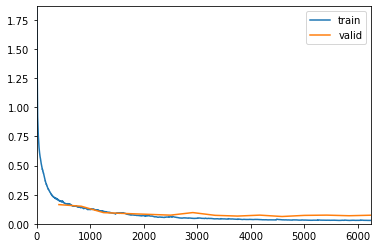

In [ ]:
learner.fit_one_cycle(15, max_lr=slice(1e-3, 1e-4))

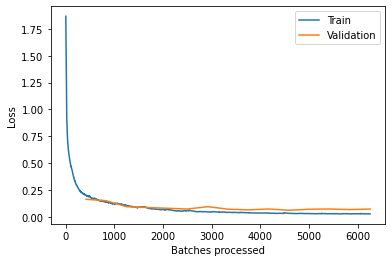

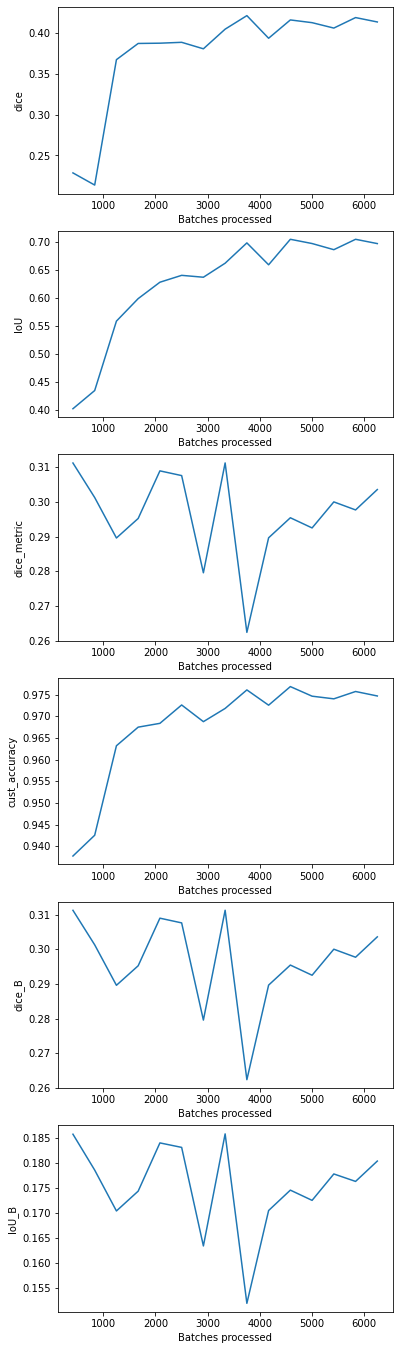

In [ ]:
learner.recorder.plot_losses()
learner.recorder.plot_metrics()

Since the both the losses seem small enough, lets predict:

In [ ]:
learner.save(model_DIR)

# Predictions

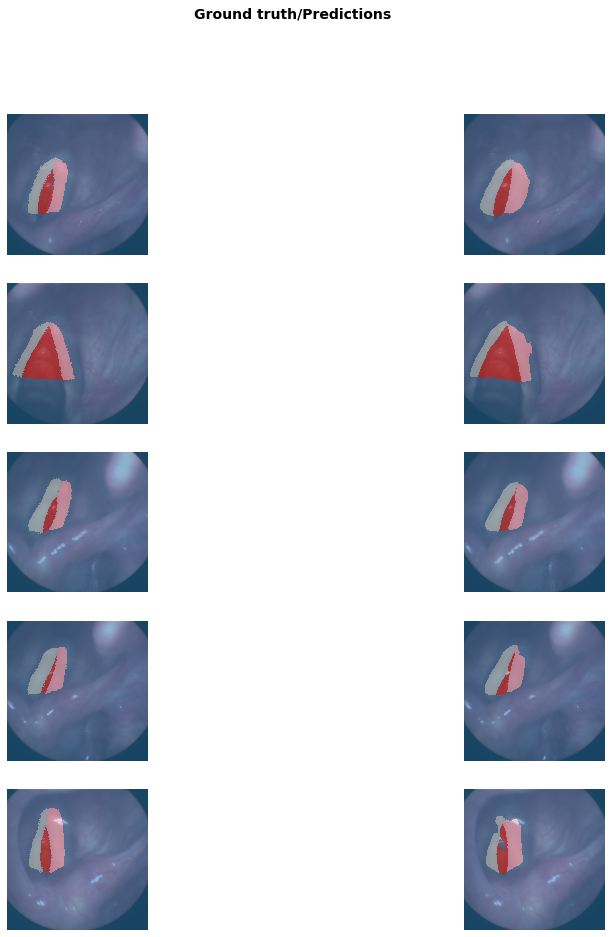

In [ ]:
learner.show_results(figsize=(15,15))

On the left is the actual images while on the left is the predictions! They look almost identical and thereby here I conclude this notebook.

If you liked this notebook, an upvote would be of tremendous help as I trot forward with my infatuation with Deep Learning :)

In [ ]:
# Export dataset version

Version = 'data/D_v_3.0.0'

bindingset_dir = os.path.abspath(os.path.join(ROOT_PATH, Version))

train_bindingset_dir = os.path.join(bindingset_dir, 'train')
test_bindingset_dir = os.path.join(bindingset_dir, 'test')

checkpath(train_bindingset_dir)
checkpath(test_bindingset_dir)

In [ ]:
# run & save bindingset

kokocounter = 0

for imgs_name in os.listdir(trainpath_):
  probs = learner.predict(open_image(os.path.join(trainpath_, imgs_name)))[2]
  kokocounter += 1
  print(imgs_name, type(probs), probs.shape, kokocounter)
  tensor_name = imgs_name.split('.')[0] + '_tensor_' + str(kokocounter) + '.pt'
  if kokocounter%4 == 0:
    torch.save(probs, os.path.join(test_bindingset_dir, tensor_name))
  else:
    torch.save(probs, os.path.join(train_bindingset_dir, tensor_name))

print('\n\nSuccessfully Completed!!!\n\n')#797

In [ ]:
# load & check bindingset tensor

kokocounter = 0

for tensor_name in os.listdir(bindingset_dir):
  y = torch.load(os.path.join(bindingset_dir, tensor_name))
  if torch.equal(y, learner.predict(open_image(os.path.join(trainpath, tensor_name.split('_tensor_')[0] + '.png')))[2]):
    print('bad ' + tensor_name)

print('\n\nCheck Completed!!!\n\n')

In [ ]:
import cv2
import seaborn as sn
from numpy.lib.function_base import average

In [ ]:
def confusion_matrix(now_imgs_DIR, now_mask_DIR, confusion_matrix):

  _SIZE = 540

  # confusion_matrix = np.zeros((12,12))

  img = open_image(now_imgs_DIR)
  mask = cv2.imread(now_mask_DIR)
  # print(now_imgs_DIR.replace('/content/drive/My Drive/09_research_main/lab_01/data/dataset_C_v_2.6.1', ''))

  # img.show(figsize=(6,6))
  # plt.show()
  # plt.imshow(mask*40)
  # plt.show()

  mask = cv2.resize(mask, (_SIZE,_SIZE))
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

  pred, pred_idx, probs = learner.predict(img)

  # plt.imshow((pred_idx.numpy()*40).reshape((_SIZE,_SIZE)))
  # plt.show()

  prediction = pred_idx.numpy()
  prediction = prediction.reshape((_SIZE,_SIZE))

  # D P
  # T T TP(True Positive)
  # T F FN(False Negative)
  # F T FP(False Positive)
  # F FS TN(True Negative)

  for i in range(0, mask.shape[0]):#-
    for j in range(0, mask.shape[1]):#|
      # print(prediction[i][j].item(),mask[i][j].item())
      confusion_matrix[prediction[i][j].item()][mask[i][j].item()] += 1

  # print(confusion_matrix)
  return confusion_matrix

In [ ]:
def get_confusion_matrix(imgs_dir, label_dir, CLASSES):
  LEN = len(CLASSES)
  cm = np.zeros((LEN,LEN))

  for get_to_name_path in os.listdir(imgs_dir):
    now_imgs_DIR = os.path.join(imgs_dir,  get_to_name_path)
    now_mask_DIR = os.path.join(label_dir, get_to_name_path)

    cm = confusion_matrix(now_imgs_DIR, now_mask_DIR, cm)
  return cm

In [ ]:
def print_cm(GET_CM, CLASSES):

  df_cm = pd.DataFrame(GET_CM, index = [i for i in CLASSES], columns = [i for i in CLASSES])
  plt.figure(figsize = (15,12))
  sn.heatmap(df_cm, annot=True)

In [ ]:
def IoU_computer(a, CLASSES):
  LEN = len(CLASSES)
  IoUstr = []
  IoU = []
  temp = 0

  for i in range(0, LEN):
    temp = 0
    for j in range(0, LEN):
      temp += a[j][i] + a[i][j]
    IoUstr += [str(a[i][i])+'/'+str(temp-a[i][i])]
    IoU += [a[i][i]/(temp-a[i][i])]

  ALL_IoU = average(IoU)

  print(IoUstr)
  print(IoU)
  print(f'IoU = {ALL_IoU:.2f}')

In [ ]:
 # maim test for acc & cm

# imgs_dir = validpath
# label_dir = validlabel

imgs_dir = testpath
label_dir = testlabel

# cm = get_confusion_matrix(imgs_dir, label_dir, classes)
print_cm(cm, classes)
IoU_computer(cm, classes)

ValueError: ignored

In [ ]:
for i in range(0, 12):
  cm[i][0] = 50
  cm[0][i] = 50
cm[1][1] = 50
df_cm = pd.DataFrame(cm, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,12))
sn.heatmap(df_cm, annot=True)

In [ ]:
cm_ = np.zeros((12,12))

cm_ = confusion_matrix(os.path.join(trainpath, 'RSLN_R_G20_1080_7679.png'), os.path.join(trainlabel, 'RSLN_R_G20_1080_7679.png'), cm_)
cm_[0][0] = 50
cm_[1][1] = 50
df_cm = pd.DataFrame(cm_, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,12))
sn.heatmap(df_cm, annot=True)

In [ ]:
# IoU computer

from numpy.lib.function_base import average
# a = np.array([[10,2,0,1],[2,10,1,0],[0,1,10,2],[0,1,2,11]])
# print(a)

a = cm_
IoUstr = []
IoU = []
temp = 0
LEN = 12

for i in range(0, LEN):
  temp = 0
  for j in range(0, LEN):
    temp += a[j][i] + a[i][j]
  IoUstr += [str(a[i][i])+'/'+str(temp-a[i][i])]
  IoU += [a[i][i]/(temp-a[i][i])]

ALL_IoU = average(IoU)

print(IoUstr)
print(IoU)
print(f'IoU = {ALL_IoU:.2f}')

In [ ]:
def prediction_map(get_list, pred_idx):
  imanopredict = []

  for i in range(0,12):
    imanopredict += [int(np.sum(np.asarray(pred_idx)==i))]

  sumR = 0
  sumL = 0

  for i in range(2, 12, 2):
    sumR += imanopredict[i]
    sumL += imanopredict[i+1]

  print('-'*25)
  for i in range(2, 12, 2):
    print(f'{imanopredict[i]/sumR*100:.2f}% = {get_list[i]}')

  print('-'*25)
  for i in range(3, 12, 2):
    print(f'{imanopredict[i]/sumL*100:.2f}% = {get_list[i]}')

  print('-'*25)

In [ ]:
# test

img = open_image(os.path.join(trainpath, '../test_imgs/RSLN_R_TEST_G21_1080_197.png'))
mask = open_mask(os.path.join(trainlabel, '../test_mask/RSLN_R_TEST_G21_1080_197.png'))
img_ = open_image(os.path.join(trainpath, '../test_imgs/RSLN_R_TEST_G21_1080_197.png')).resize((1,540,540))

pred,pred_idx,probs = learner.predict(img)

prediction_map(classes, pred_idx)

_,axs = plt.subplots(1,3, figsize=(16,16))
img.show(ax=axs[0], title='no mask')
img_.show(ax=axs[1], y=pred, title='prediction'+str(np.unique(np.asarray(pred_idx))))
img.show(ax=axs[2], y=mask, title='mask'+str(np.unique(cv2.imread(os.path.join(trainlabel, '../test_mask/RSLN_R_TEST_G21_1080_197.png')))))

#don't know how to say

In [ ]:
# many test
imgs_DIR = os.path.join(ROOT_PATH, 'data/dataset_C_v_2.6.1/test_imgs')

img_ = np.zeros((1, 540, 540))

for get_file in os.listdir(imgs_DIR):
  if get_file.split('_')[3] == 'G21':
    img = open_image(os.path.join(imgs_DIR, get_file))
    pred, pred_idx, probs = learner.predict(img)
    img_ = np.concatenate([img_, np.asarray(pred_idx)])

prediction_map(classes, img_)

In [ ]:
img = open_image(os.path.join(trainpath, '../test_imgs/RSLN_R_TEST_G21_1080_197.png'))
pred, pred_idx, probs = learner.predict(img)

print(type(pred), pred.shape)
print(type(pred_idx), pred_idx.shape)
print(type(probs), probs.shape)

In [ ]:
# test 1
# -------------------------
# 18.51% = vfright_normal
# 52.16% = vfright_rln_R
# 29.16% = vfright_rln_L
# 0.00% = vfright_rsln_R
# 0.17% = vfright_rsln_L
# -------------------------
# 0.06% = vfleft_normal
# 0.12% = vfleft_rln_R
# 95.35% = vfleft_rln_L
# 0.03% = vfleft_rsln_R
# 4.45% = vfleft_rsln_L
# -------------------------

In [ ]:
# test 2
# -------------------------
# 92.04% = vfright_normal
# 0.11% = vfright_rln_R
# 0.01% = vfright_rln_L
# 0.00% = vfright_rsln_R
# 7.83% = vfright_rsln_L
# -------------------------
# 96.12% = vfleft_normal
# 1.52% = vfleft_rln_R
# 0.86% = vfleft_rln_L
# 0.00% = vfleft_rsln_R
# 1.49% = vfleft_rsln_L
# -------------------------

In [ ]:
# single test
# jpgs_DIR = '/content/drive/My Drive/09_research_main/lab_01/data/test/test1_1203397F_20140502_jpg_CNN/jpgs488'
jpgs_DIR = '/content/drive/My Drive/09_research_main/lab_01/data/test/test2_2495800H_20190212_jpg _CNN/jpgs'


IMA = 100

img = open_image(os.path.join(jpgs_DIR, str(IMA)+'.png'))
img_ = open_image(os.path.join(jpgs_DIR, str(IMA)+'.png')).resize((1,540,540))

pred,pred_idx,probs = learner.predict(img)

prediction_map(classes, pred_idx)

_,axs = plt.subplots(1,2, figsize=(16,16))
img.show(ax=axs[0], title='no mask')
img_.show(ax=axs[1], y=pred, title='prediction'+str(np.unique(np.asarray(pred_idx))))

In [ ]:
jpgs_DIR = '/content/drive/My Drive/09_research_main/lab_01/data/test/test1_1203397F_20140502_jpg_CNN/jpgs488'

img_ = np.zeros(10)

for get_file in os.listdir(jpgs_DIR):
  img = open_image(os.path.join(jpgs_DIR, get_file))
  pred, pred_idx, probs = learner.predict(img)

  img = np.unique(np.asarray(pred_idx))
  img_ = np.concatenate([img_, img])

  print(get_file)
  print(img)